In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Table of contents

* [Data Dictionary](#datadic)
* [Data Cleaning](#cleanup)
    * [1. Overview](#overview)
    * [2. Checking duplicates and missing values](#nn)
* [Data Tranformation](#transform)
    * [1. Removing **PERFORM_CNS_SCORE_DESCRIPTION**](#cnsdes)
    * [2. Extracting **DISBURSAL_DATE** to **DISBURSAL_YEAR**, **DISBURSAL_MONTH**, **DISBURSAL_DAY**](#disbursal)
    * [3. Converting **AVERAGE_ACCT_AGE**, and **CREDIT_HISTORY_LENGTH** to numeric](#numeric)
    * [4. Calculating age of borrowers](#age)
    * [5. Checking single-value columns](#single)
* [EDA](#eda)
    * [1. **LOAN_DEFAULT**](#loan_default)
    * [2. **PERFORM_CNS_SCORE_DESCRIPTION**](#cns)
    * [3. Default rate by state](#default_state)
    * [4. **LTV**](#ltv)
    * [5. **LOAN_DEFAULT** by month](#default_month)
* [Check multicollinearity](#multicollinearity)    
* [Data Split](#datasplit)
* [Modelling](#model)
    * [1. Logistic Regression](#logit)
    * [2. Decision Tree](#dt)
    * [3. Random Forest](#rf)
    * [4. XGB](#xgb)
* [Threshold Adjustment](#ta)    
* [Conclusion](#conclusion)
* [Feature Selection](#fs)    




# Data Dictionary  <a class="anchor" id="datadic"></a>

In [2]:
from pandas import option_context
data_dic=pd.read_csv('Data_dictionary.csv',index_col=0 ,keep_default_na=False)
data_dic.columns = ['Description','']
with option_context('display.max_colwidth',400):
    display(data_dic)

,Description,
Variable Name,,
UNIQUE_ID,Identifier for customers,
LOAN_DEFAULT,Payment default in the first EMI on due date,
DISBURSED_AMOUNT,Amount of Loan disbursed,A loan is disbursed when the agreed-upon amount is actually paid into the borrower's account and is available for use. The cash has been debited from the lender's account and credited to the borrower's account.
ASSET_COST,Cost of the Asset,
LTV,Loan to Value of the asset,
BRANCH_ID,Branch where the loan was disbursed,
SUPPLIER_ID,Vehicle Dealer where the loan was disbursed,
MANUFACTURER_ID,"Vehicle manufacturer(Hero, Honda, TVS etc.)",
CURRENT_PINCODE,Current pincode of the customer,


# Data Cleaning  <a class="anchor" id="cleanup"></a>

## 1. Overview <a class="anchor" id="overview"></a>

In [3]:
df=pd.read_csv('train.csv', index_col=0)

pd.set_option('display.max_columns', None)
df.head(3)

,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,DISBURSAL_DATE,STATE_ID,EMPLOYEE_CODE_ID,MOBILENO_AVL_FLAG,AADHAR_FLAG,PAN_FLAG,VOTERID_FLAG,DRIVING_FLAG,PASSPORT_FLAG,PERFORM_CNS_SCORE,PERFORM_CNS_SCORE_DESCRIPTION,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
UNIQUEID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
420825,50578,58400,89.55,67,22807,45,1441,01-01-1984,Salaried,03-08-2018,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
537409,47145,65550,73.23,67,22807,45,1502,31-07-1985,Self employed,26-09-2018,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
417566,53278,61360,89.63,67,22807,45,1497,24-08-1985,Self employed,01-08-2018,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0


In [4]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset has 233154 rows and 40 columns.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233154 entries, 420825 to 630213
Data columns (total 40 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   DISBURSED_AMOUNT                     233154 non-null  int64  
 1   ASSET_COST                           233154 non-null  int64  
 2   LTV                                  233154 non-null  float64
 3   BRANCH_ID                            233154 non-null  int64  
 4   SUPPLIER_ID                          233154 non-null  int64  
 5   MANUFACTURER_ID                      233154 non-null  int64  
 6   CURRENT_PINCODE_ID                   233154 non-null  int64  
 7   DATE_OF_BIRTH                        233154 non-null  object 
 8   EMPLOYMENT_TYPE                      225493 non-null  object 
 9   DISBURSAL_DATE                       233154 non-null  object 
 10  STATE_ID                             233154 non-null  int64  
 11  EMPLOYEE

In [6]:
# look at object columns
df.loc[:, df.dtypes == 'object'].head(2)

,DATE_OF_BIRTH,EMPLOYMENT_TYPE,DISBURSAL_DATE,PERFORM_CNS_SCORE_DESCRIPTION,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH
UNIQUEID,,,,,,
420825,01-01-1984,Salaried,03-08-2018,No Bureau History Available,0yrs 0mon,0yrs 0mon
537409,31-07-1985,Self employed,26-09-2018,I-Medium Risk,1yrs 11mon,1yrs 11mon


We see that we can convert all these columns into numeric type by:

- calculating age of borrowers based on `DATE_OF_BIRTH`
- OneHotEncoding `EMPLOYMENT_TYPE`
- extracting `DISBURSAL_DATE` to 3 columms: `DISBURSAL_YEAR`, `DISBURSAL_MONTH`, and `DISBURSAL_DAY`
- converting `AVERAGE_ACCT_AGE` and `CREDIT_HISTORY_LENGTH` to the number of months

Also, considering that `PERFORM_CNS_SCORE_DESCRIPTION` presents the same information with `PERFORM_CNS_SCORE`, it will be removed to avoid collinearity.

## 2. Checking duplicates and missing values <a class="anchor" id="nn"></a>

In [7]:
# check duplicated rows
df.duplicated().sum()

0

In [8]:
# check NaN values
df.isna().sum()

DISBURSED_AMOUNT                          0
ASSET_COST                                0
LTV                                       0
BRANCH_ID                                 0
SUPPLIER_ID                               0
MANUFACTURER_ID                           0
CURRENT_PINCODE_ID                        0
DATE_OF_BIRTH                             0
EMPLOYMENT_TYPE                        7661
DISBURSAL_DATE                            0
STATE_ID                                  0
EMPLOYEE_CODE_ID                          0
MOBILENO_AVL_FLAG                         0
AADHAR_FLAG                               0
PAN_FLAG                                  0
VOTERID_FLAG                              0
DRIVING_FLAG                              0
PASSPORT_FLAG                             0
PERFORM_CNS_SCORE                         0
PERFORM_CNS_SCORE_DESCRIPTION             0
PRI_NO_OF_ACCTS                           0
PRI_ACTIVE_ACCTS                          0
PRI_OVERDUE_ACCTS               

There are no duplicates but **7661** NaN values in column `EMPLOYMENT_TYPE`, let's look at the categories it carries.

In [9]:
df['EMPLOYMENT_TYPE'].value_counts()

Self employed    127635
Salaried          97858
Name: EMPLOYMENT_TYPE, dtype: int64

In [10]:
# Let's replace NaN by Unknown
df['EMPLOYMENT_TYPE'] = df['EMPLOYMENT_TYPE'].fillna('Unknown')

# Sanity check
df['EMPLOYMENT_TYPE'].value_counts()

Self employed    127635
Salaried          97858
Unknown            7661
Name: EMPLOYMENT_TYPE, dtype: int64

# Data Transformation  <a class="anchor" id="transform"></a>

## 1. Removing `PERFORM_CNS_SCORE_DESCRIPTION` <a class="anchor" id="cnsdes"></a>

In [11]:
df_original=df

In [12]:
df=df.drop(columns='PERFORM_CNS_SCORE_DESCRIPTION')

In [13]:
# sanity check
'PERFORM_CNS_SCORE_DESCRIPTION' not in df.columns

True

## 2. Extracting `DISBURSAL_DATE` to `DISBURSAL_YEAR`, `DISBURSAL_MONTH`, `DISBURSAL_DAY`  <a class="anchor" id="disbursal"></a>

In [14]:
df[['DISBURSAL_DATE']].head()

,DISBURSAL_DATE
UNIQUEID,
420825,03-08-2018
537409,26-09-2018
417566,01-08-2018
624493,26-10-2018
539055,26-09-2018


In [15]:
# change datatype
df['DISBURSAL_DATE']=df['DISBURSAL_DATE'].astype('datetime64')

# extract to year, month, day
df['DISBURSAL_YEAR'] = df['DISBURSAL_DATE'].dt.year
df['DISBURSAL_MONTH'] = df['DISBURSAL_DATE'].dt.month
df['DISBURSAL_DAY'] = df['DISBURSAL_DATE'].dt.day

# show
df.iloc[:,-5:].head(3)

,NO_OF_INQUIRIES,LOAN_DEFAULT,DISBURSAL_YEAR,DISBURSAL_MONTH,DISBURSAL_DAY
UNIQUEID,,,,,
420825,0,0,2018,3,8
537409,0,1,2018,9,26
417566,0,0,2018,1,8


In [16]:
# drop DISBURSAL_DATE
df.drop(columns='DISBURSAL_DATE', inplace=True)

# sanity check 
'DISBURSAL_DATE' not in df.columns

True

In [17]:
# sanity check
print(df['DISBURSAL_YEAR'].dtype, df['DISBURSAL_MONTH'].dtype, df['DISBURSAL_DAY'].dtype)

int64 int64 int64


## 3. Converting `AVERAGE_ACCT_AGE` and `CREDIT_HISTORY_LENGTH` to numeric  <a class="anchor" id="numeric"></a>

In [18]:
df[['AVERAGE_ACCT_AGE','CREDIT_HISTORY_LENGTH']].head()

,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH
UNIQUEID,,
420825,0yrs 0mon,0yrs 0mon
537409,1yrs 11mon,1yrs 11mon
417566,0yrs 0mon,0yrs 0mon
624493,0yrs 8mon,1yrs 3mon
539055,0yrs 0mon,0yrs 0mon


In [19]:
# convert to number of months
df['AVERAGE_ACCT_AGE'] = df['AVERAGE_ACCT_AGE'].apply(lambda x: int(x.split()[0][:-3])*12 + int(x.split()[1][:-3]))
df['CREDIT_HISTORY_LENGTH'] = df['CREDIT_HISTORY_LENGTH'].apply(lambda x: int(x.split()[0][:-3])*12 + int(x.split()[1][:-3]))

# sanity check
df[['AVERAGE_ACCT_AGE','CREDIT_HISTORY_LENGTH']].head()

,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH
UNIQUEID,,
420825,0,0
537409,23,23
417566,0,0
624493,8,15
539055,0,0


In [20]:
# sanity check datatype
print(df['AVERAGE_ACCT_AGE'].dtype, df['CREDIT_HISTORY_LENGTH'].dtype)

int64 int64


## 4. Calculating age of borrowers  <a class="anchor" id="age"></a>

In [21]:
# change datatype
df['DATE_OF_BIRTH'] = df['DATE_OF_BIRTH'].astype('datetime64')

# calculate age
today = datetime.today()
df['AGE'] = ((today - df['DATE_OF_BIRTH'])/np.timedelta64(1,'Y')).astype('int64')

# sanity check
df[['DATE_OF_BIRTH','AGE']].head()

,DATE_OF_BIRTH,AGE
UNIQUEID,,
420825,1984-01-01,39
537409,1985-07-31,38
417566,1985-08-24,38
624493,1993-12-30,29
539055,1977-09-12,46


In [22]:
# sanity check
print(df['AGE'].dtype)

int64


In [23]:
# drop DATE_OF_BIRTH
df=df.drop(columns='DATE_OF_BIRTH')

# sanity check
'DATE_OF_BIRTH' not in df.columns

True

## 5. Checking single-value columns  <a class="anchor" id="single"></a>

In [24]:
for i in df.columns:
    if len(set(df[i]))==1:
        print(i)

MOBILENO_AVL_FLAG
DISBURSAL_YEAR


In [25]:
# look into it
print(set(df['MOBILENO_AVL_FLAG']))
print(set(df['DISBURSAL_YEAR']))

{1}
{2018}


- `MOBILENO_AVL_FLAG` contains one value only, which is '1', since all borrowers provide their mobile phone number.
- Values for `DISBURSAL_YEAR` is all 2018.

Let's drop them.

In [26]:
df.drop(columns=['MOBILENO_AVL_FLAG','DISBURSAL_YEAR'], inplace=True)

# sanity check 
('MOBILENO_AVL_FLAG' and 'DISBURSAL_YEAR') not in df.columns

True

# EDA  <a class="anchor" id="eda"></a>

### 1. `LOAN_DEFAULT` <a class="anchor" id="loan_default"></a>

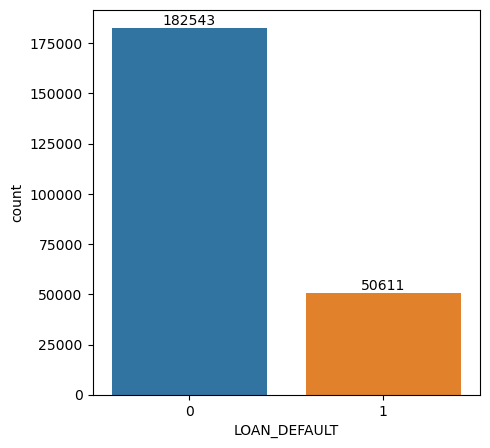

In [27]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x='LOAN_DEFAULT', data=df)
ax.bar_label(ax.containers[0])
plt.show();

# ax.figure.savefig('loan_count.png')

In [28]:
# check class ratio
df['LOAN_DEFAULT'].value_counts(normalize=True)

0    0.782929
1    0.217071
Name: LOAN_DEFAULT, dtype: float64

The dataset is pretty imbalanced. To deal with this, in terms of models, Decision trees frequently perform well on imbalanced data. However, tree ensembles (Random Forests, Gradient Boosted Trees, etc.) almost always outperform singular decision trees, so they will be candidates worth considering. Regarding approach, we would upsample the minority class, then optimize for **F1** score with `class_weight` hyperparameter.

### 2. `PERFORM_CNS_SCORE_DESCRIPTION` <a class="anchor" id="cns"></a>

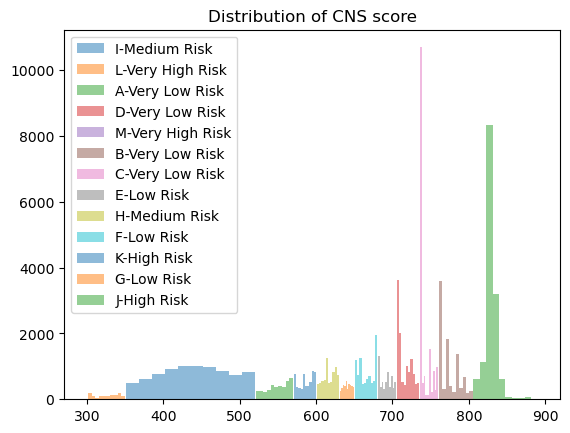

In [29]:
# look at the distribution of risk types
risk_group=[group for group in df_original['PERFORM_CNS_SCORE_DESCRIPTION'].unique() if group.endswith('k')]
for i in risk_group:
    plt.hist(df_original.loc[df_original['PERFORM_CNS_SCORE_DESCRIPTION']==i]['PERFORM_CNS_SCORE'],label=i,alpha=0.5)
plt.legend(loc='upper left')
plt.title('Distribution of CNS score')
plt.show()

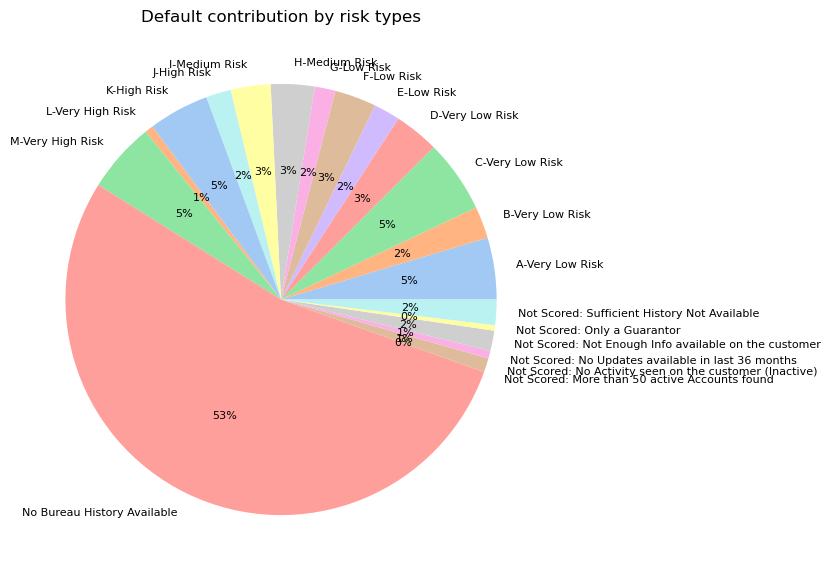

In [44]:
default_risk=df_original.groupby('PERFORM_CNS_SCORE_DESCRIPTION').sum()['LOAN_DEFAULT']

# define Seaborn color palette
palette_color = sns.color_palette('pastel')

# plot
plt.figure(figsize=(40,7))
plt.pie(default_risk, labels=default_risk.index, colors=palette_color, 
        autopct='%.0f%%', textprops={'fontsize': 8})
plt.title('Default contribution by risk types')
# plt.legend(loc='best')

# plt.savefig('risk_default.png')
# display
plt.show()

We can see that most of the loan defaults come from `No_History` and `Very_Low_Risk` groups. Of all default cases, **53%** comes from `No_History`, and surprisingly, **15%** from`Very_Low_Risk` (4 groups A,B,C,D combined) .

### 2. Default rate by state <a class="anchor" id="default_state"></a>

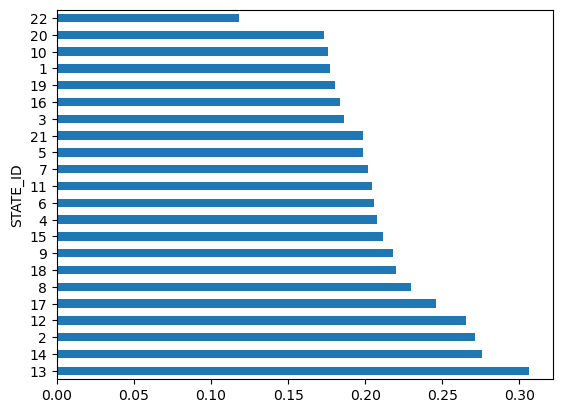

In [45]:
default_state=df.groupby('STATE_ID')['LOAN_DEFAULT'].mean().sort_values(ascending=False)
default_state.plot(kind='barh');

We can see that default rate is different between states. In fact, `STATE_ID` **13, 14, 2 and 12** have very high percentage of default (**>25%**), in which at least **1 out of 4** borrowers will default in these states.

### 4. `LTV` <a class="anchor" id="ltv"></a>

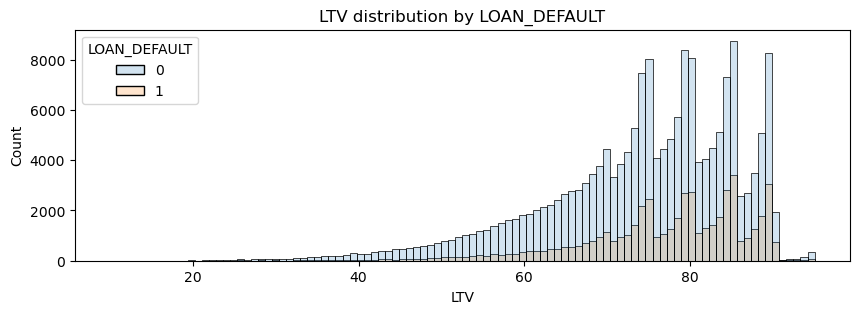

In [46]:
plt.figure(figsize=(10,3))
sns.histplot(data=df, bins=100, x=df['LTV'], hue='LOAN_DEFAULT', alpha=0.2)
plt.title('LTV distribution by LOAN_DEFAULT');

We can see that default cases are mostly between **70** and **90** of `LTV`.

### 5. `LOAN_DEFAULT` by month <a class="anchor" id="default_month"></a>

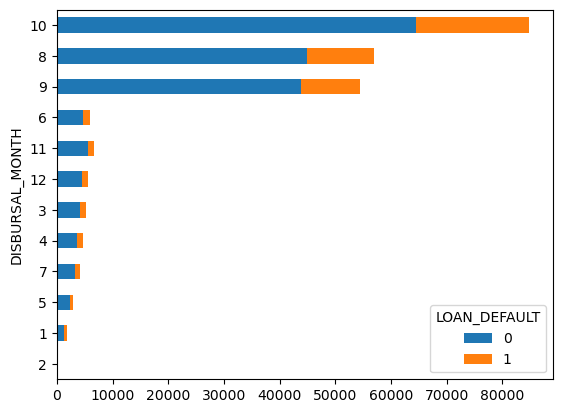

In [47]:
month_default=df.groupby('DISBURSAL_MONTH')['LOAN_DEFAULT'].value_counts().unstack().sort_values(by=1)
month_default.plot(kind='barh', stacked=True);

We can see that the number of defaults was unusually higher in October, August, and September. According to [Wikipedia](https://en.wikipedia.org/wiki/2018_in_India), we see that India went through a lot of upheavals in these months in 2018, such as:

- August 10–20: Floods in Kerala, which was the worst flood to hit the state in a century. This might be the reason for the default rate in this state (STATE_ID = 14) ~ 27.5%.
- Sept 14: Infrastructure finance company IL&FS defaulted on payment obligations to lenders and failed to meet the commercial paper redemption obligations thereby triggering panic and liquidity crisis in the markets.
- October 10: train derailing in the state of Uttar Pradesh while Amritsar train disaster happened one day before -  October 19.

All of these might affect the financial stability of borrowers, causing more default cases than the other months.

# Check multicollinearity <a class="anchor" id="multicollinearity"></a>

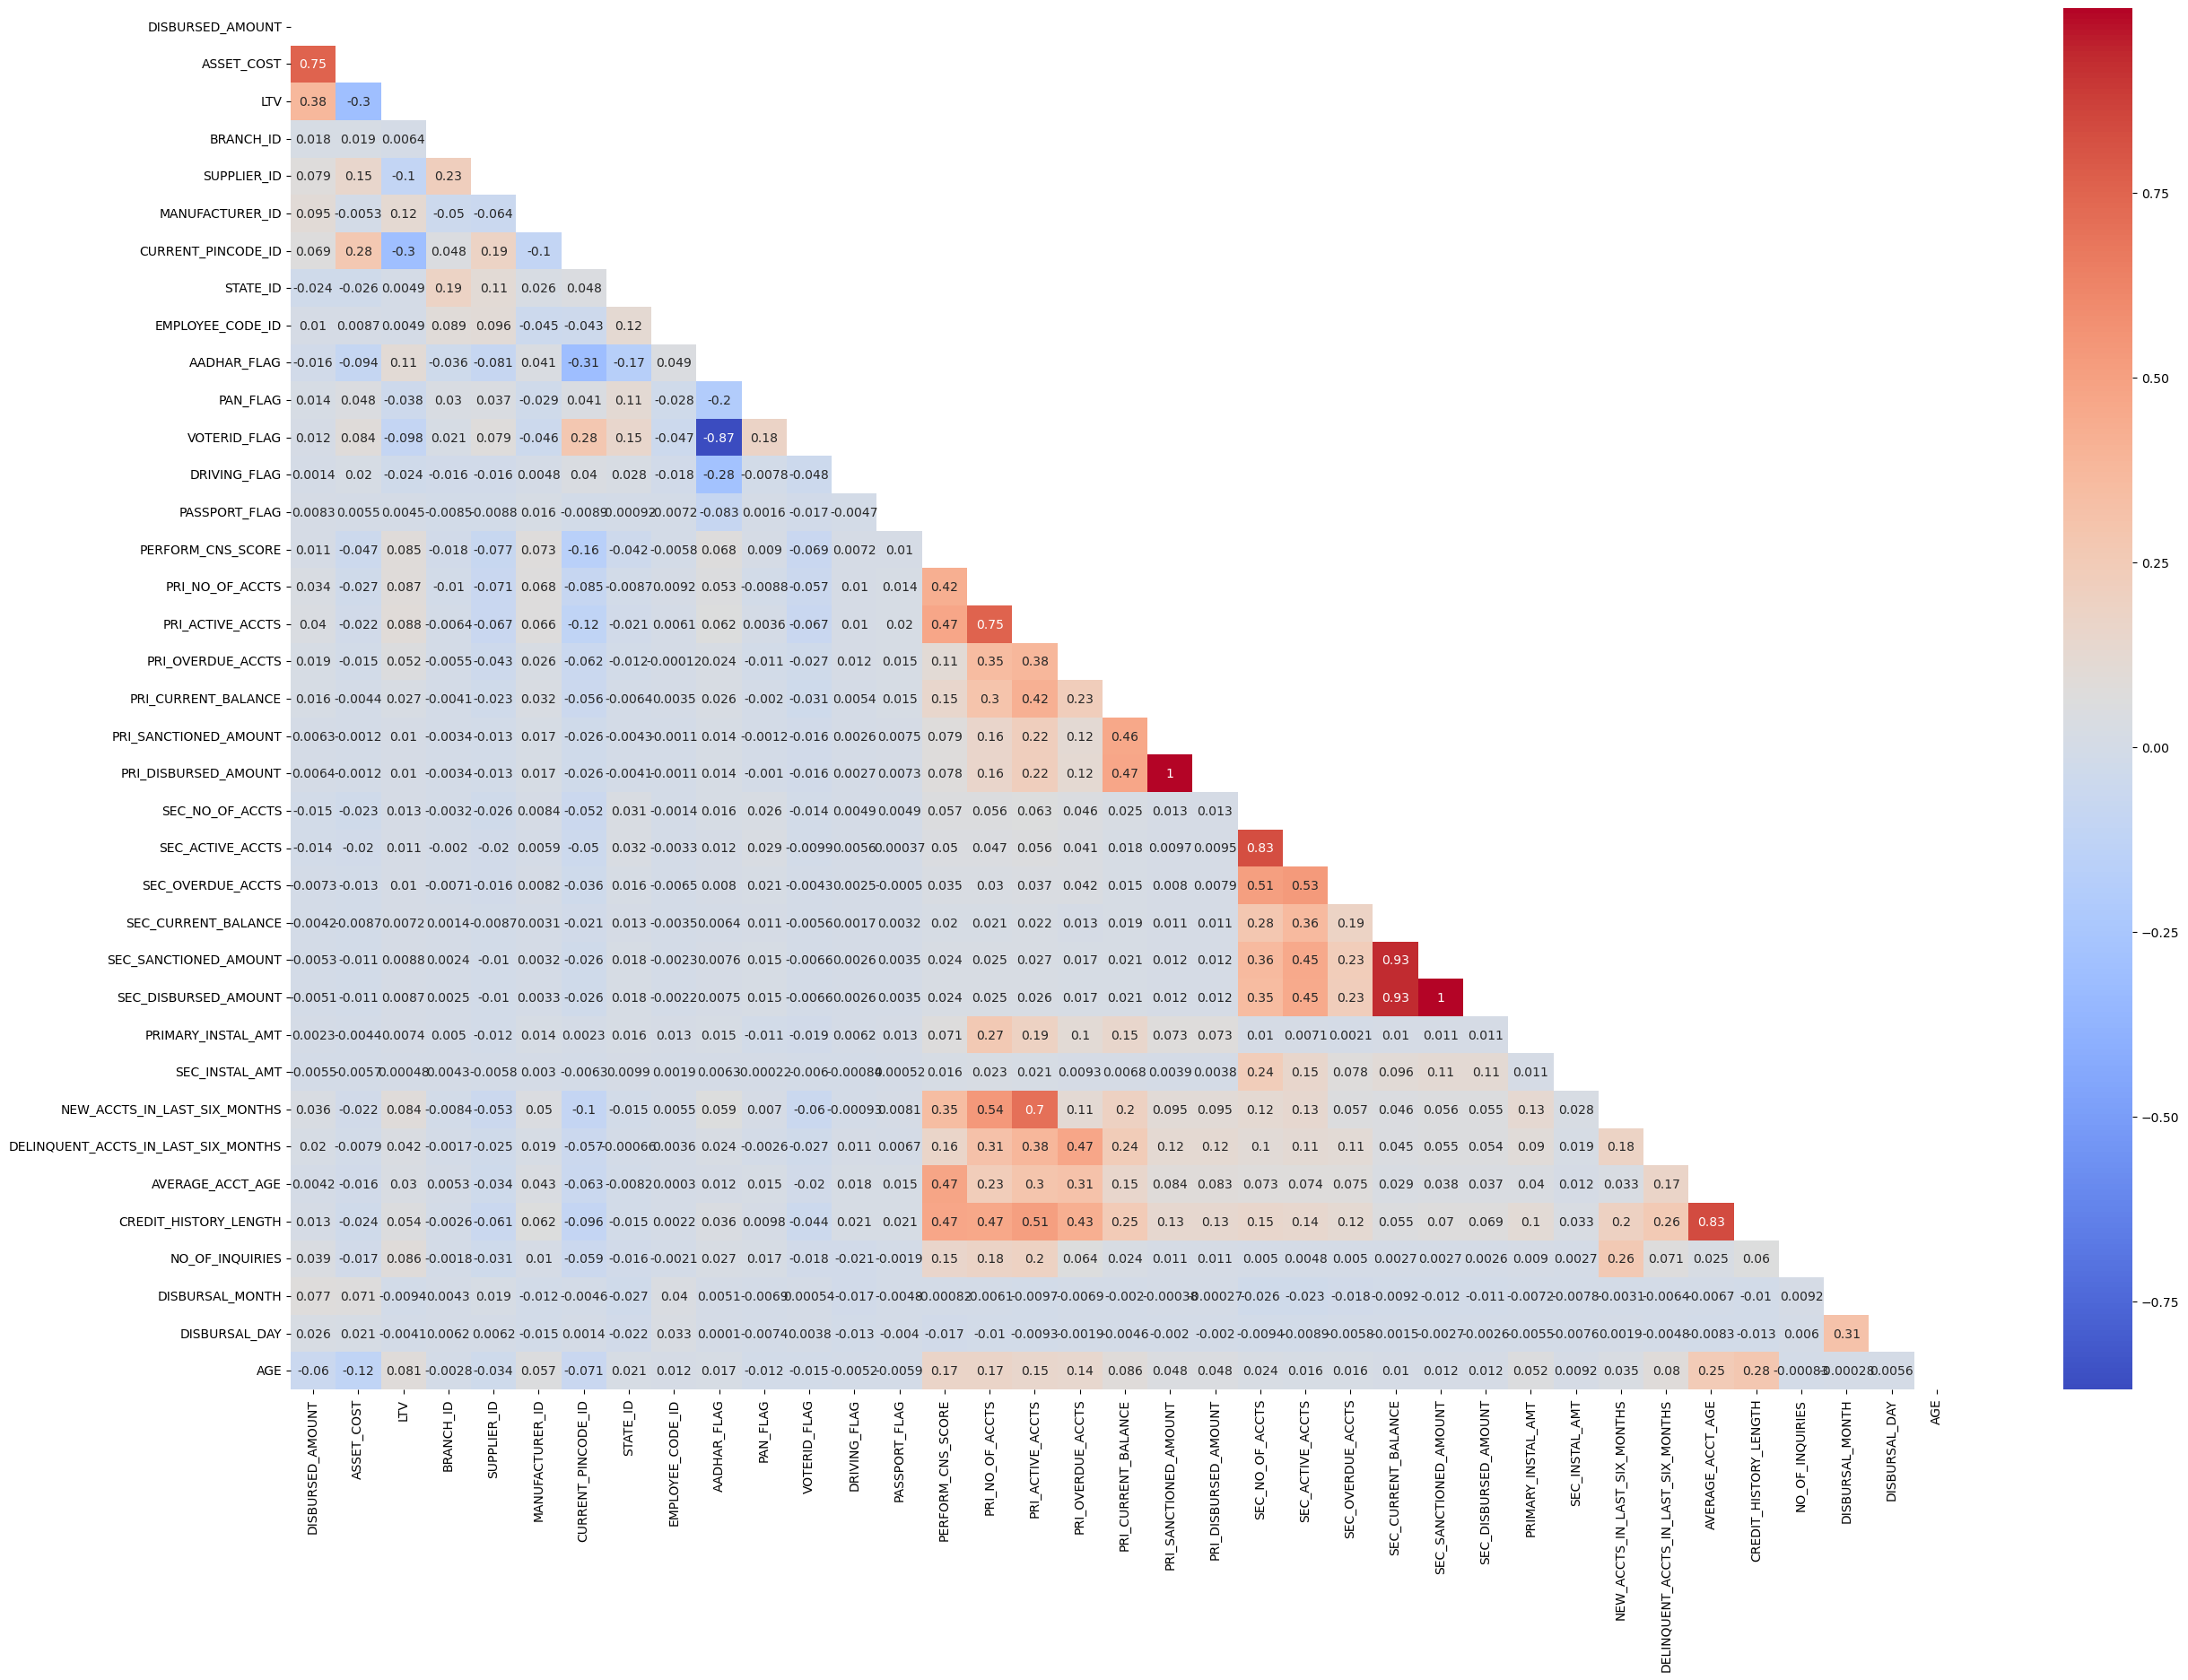

In [48]:
# heatmap of correlation
plt.figure(figsize=(30,20))
matrix = np.triu(df.drop(columns=['LOAN_DEFAULT']).corr())
sns.heatmap(df.drop(columns=['LOAN_DEFAULT']).corr(), annot=True, mask=matrix, cmap='coolwarm')
plt.show()

We see there exists multicollinearity, i.e between `ASSET_COST` and `DISBURSED_AMOUNT`, or `CREDIT_HISTORY_LENGTH` and `AVERAGE_ACCT_AGE`. Given the similar implication of many columns, such as:
- `ASSET_COST` and `DISBURSED_AMOUNT`
- `VOTERID_FLAG` and `AADHAR_FLAG` 
- `PRI_ACTIVE_ACCTS` and `PRI_N0_OF_ACCTS` and `NEW_ACCTS_IN_LAST_SIX_MONTHS`
- `PRI_SANCTIONED_AMOUNT` and `PRI_DISBURSED_AMOUNT`
- `SEC_NO_OF_ACCTS` and `SEC_ACTIVE_ACCTS`
- `SEC_CURRENT_BALANCE` and `SEC_SANCTIONED_AMOUNT` and `SEC_DISBURSED_AMOUNT` 
- `AVERAGE_ACCT_AGE` and `CREDIT_HISTORY_LENGTH`

The solution is to drop either of them. Below are the columns that we'll drop altogether.

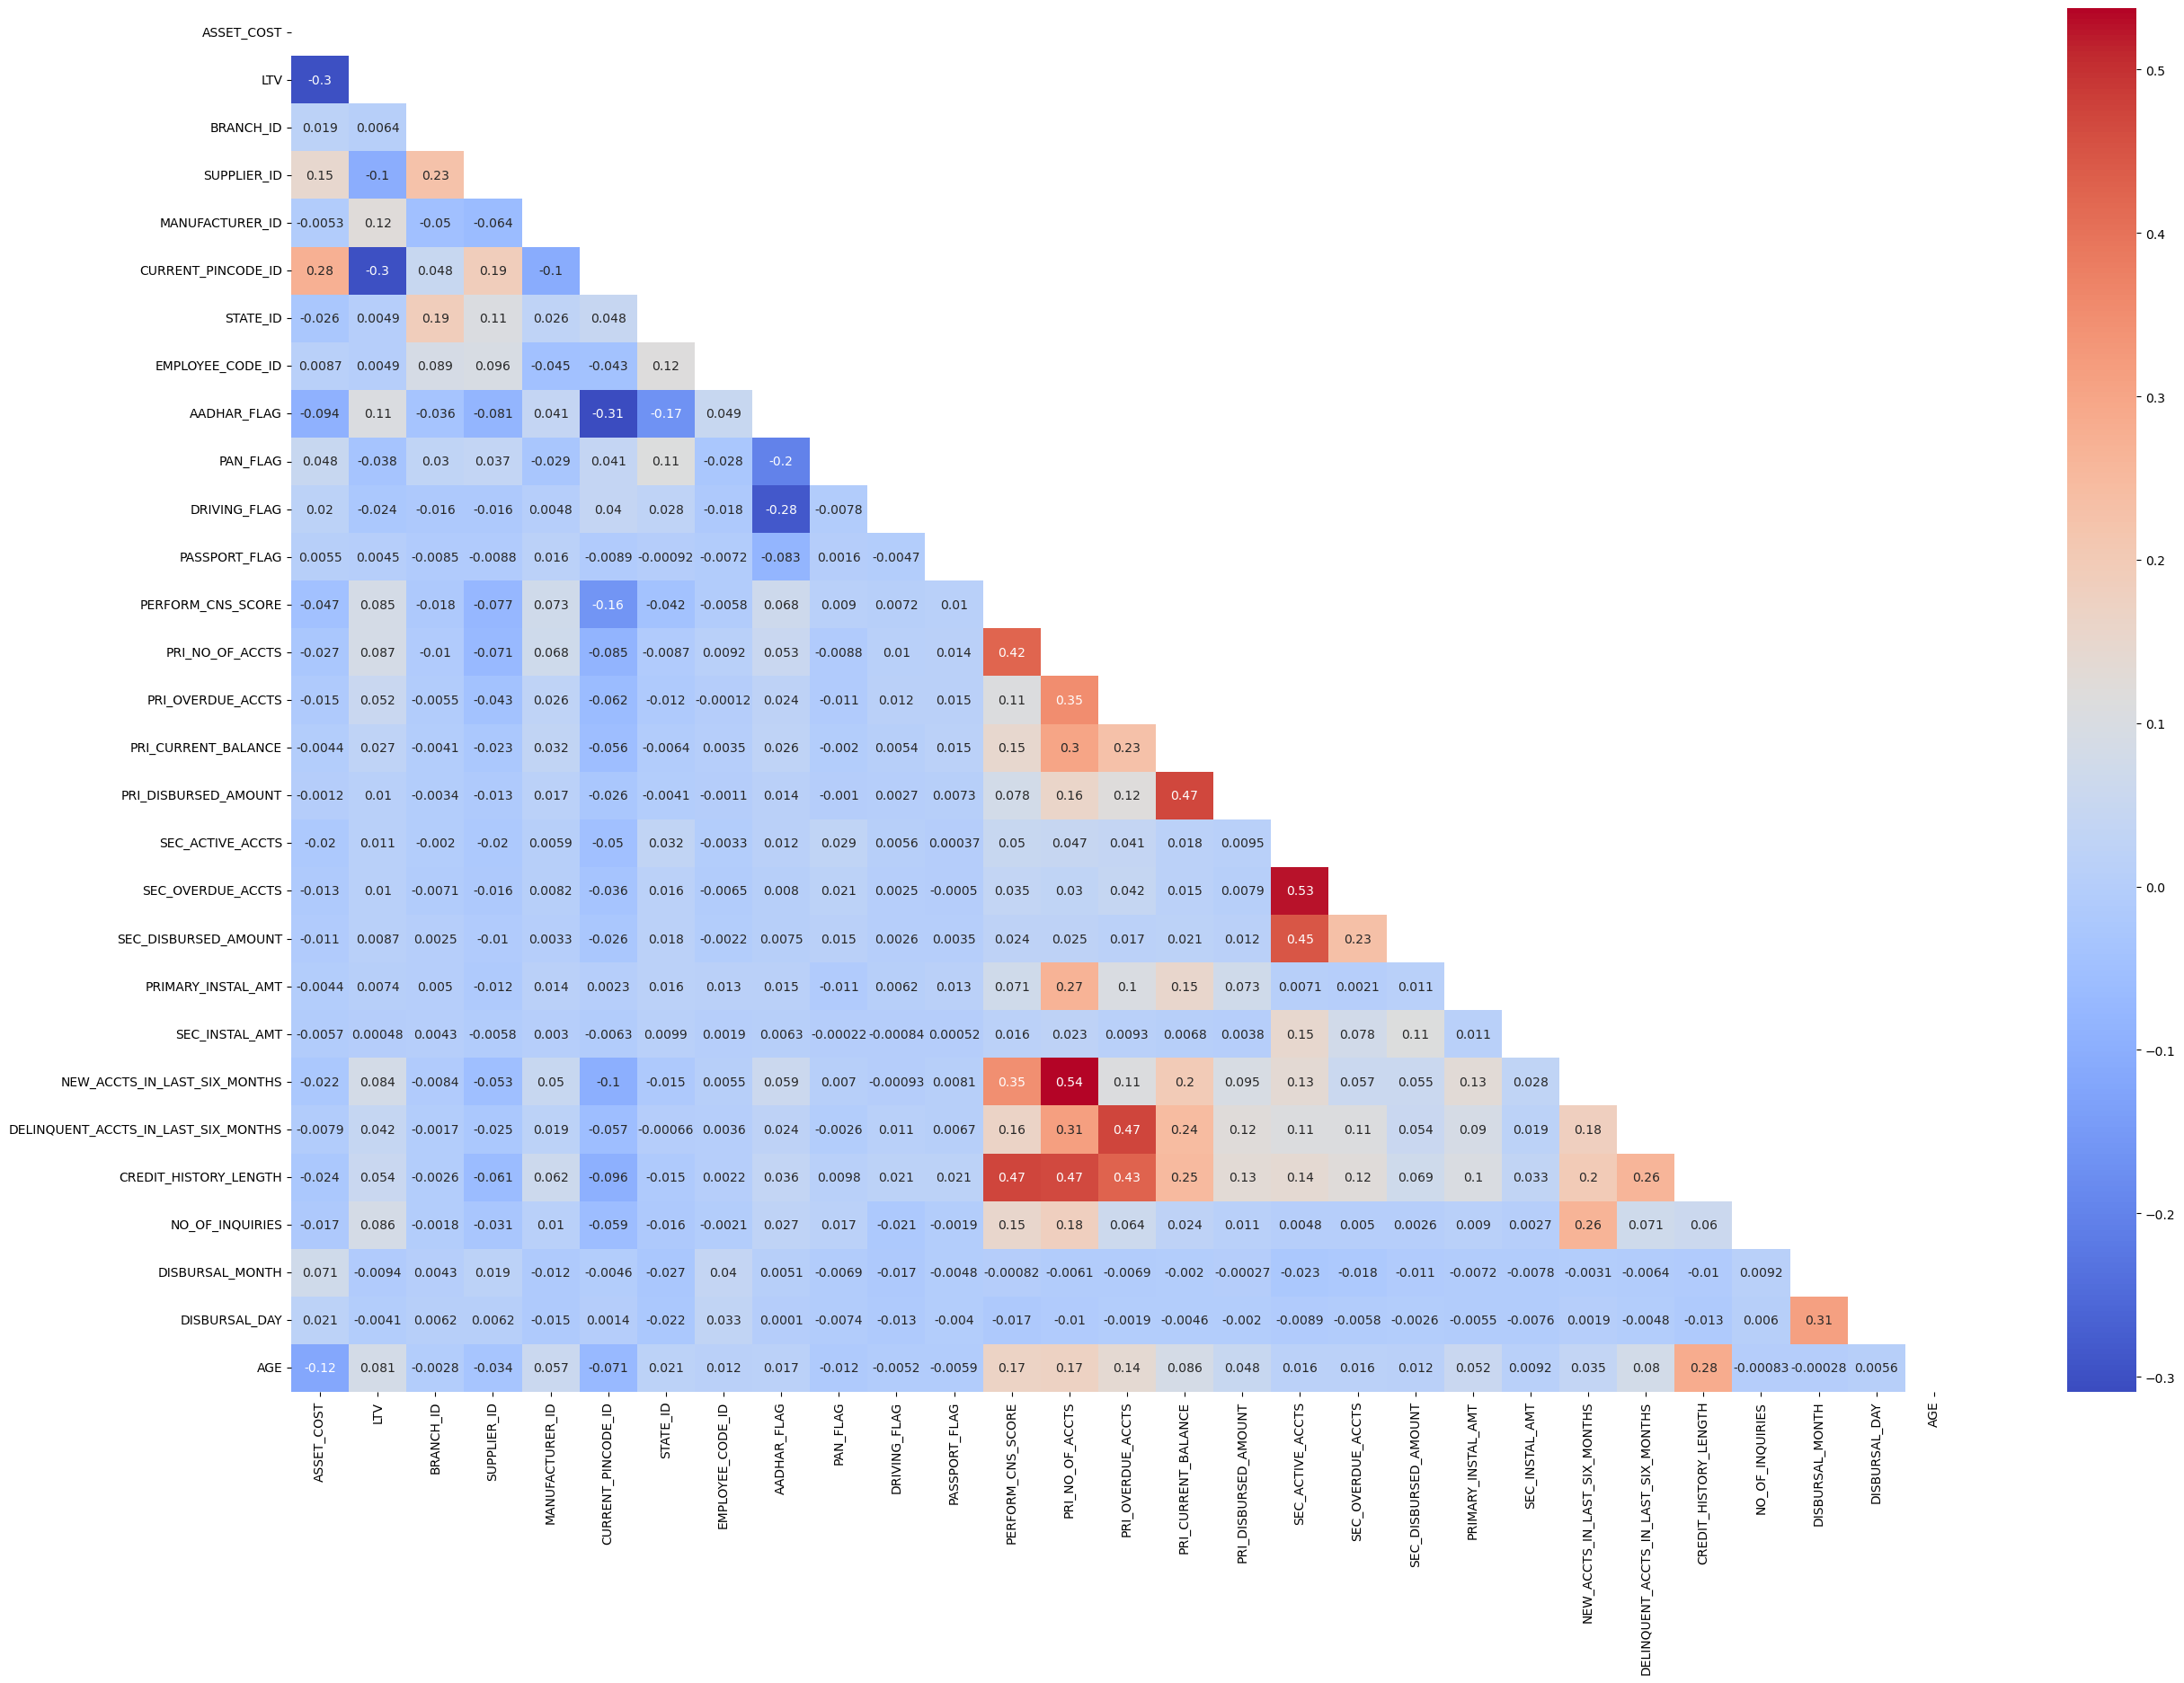

In [49]:
df=df.drop(columns=['DISBURSED_AMOUNT','VOTERID_FLAG','PRI_ACTIVE_ACCTS',
                    'PRI_SANCTIONED_AMOUNT','SEC_NO_OF_ACCTS','SEC_CURRENT_BALANCE',
                    'SEC_SANCTIONED_AMOUNT','AVERAGE_ACCT_AGE'])
# check
plt.figure(figsize=(30,20))
matrix = np.triu(df.drop(columns='LOAN_DEFAULT').corr())
sns.heatmap(df.drop(columns='LOAN_DEFAULT').corr(), annot=True, mask=matrix, cmap='coolwarm')
plt.show()

No multicollinearity now, the dataset is ready for modelling.

# Data Split <a class="anchor" id="datasplit"></a>

In [50]:
X=df.drop(columns=['LOAN_DEFAULT'])
y=df['LOAN_DEFAULT']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)

In [52]:
X_train.shape

(174865, 30)

In [53]:
X_test.shape

(58289, 30)

# Modelling <a class="anchor" id="model"></a>

In [69]:
# look at what object columns we're having now
df.loc[:, df.dtypes == 'object'].head(2)

,EMPLOYMENT_TYPE
UNIQUEID,
420825,Salaried
537409,Self employed


## 1. Logistic Regression <a class="anchor" id="logit"></a>

In [54]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

imba_pipeline = make_pipeline(
            RandomOverSampler(random_state=101),        
            make_column_transformer((OneHotEncoder(drop = 'first'), make_column_selector(dtype_include=object)), # OHE all object columns
                                    remainder='passthrough'), # pass through the rest (numeric) columns
            LogisticRegression(random_state=11, max_iter=1000))

param_grid = [{'logisticregression__solver':['lbfgs'],
               'logisticregression__penalty':['l2', 'None'],
               'logisticregression__C': [10**i for i in range (-4,4)],
               'logisticregression__class_weight': [{0:1,1:2},{0:1,1:3}, {0:1,1:4}, None],
               'randomoversampler__sampling_strategy': [1/2,1/3,1/4]},
              
              {'logisticregression__solver':['liblinear'],
               'logisticregression__penalty':['l1', 'l2'],
               'logisticregression__C': [10**i for i in range (-4,4)],
               'logisticregression__class_weight': [{0:1,1:2},{0:1,1:3}, {0:1,1:4}, None],
               'randomoversampler__sampling_strategy': [1/2,1/3,1/4]},
              
              {'logisticregression__solver':['newton-cg'],
               'logisticregression__penalty':['l2', 'None'],
               'logisticregression__C': [10**i for i in range (-4,4)],
               'logisticregression__class_weight': [{0:1,1:2},{0:1,1:3}, {0:1,1:4}, None],
               'randomoversampler__sampling_strategy': [1/2,1/3,1/4]},
              
              {'logisticregression__solver':['sag'],
               'logisticregression__penalty':['l2', 'None'],
               'logisticregression__C': [10**i for i in range (-4,4)],
               'logisticregression__class_weight': [{0:1,1:2},{0:1,1:3}, {0:1,1:4}, None],
               'randomoversampler__sampling_strategy': [1/2,1/3,1/4]},
              
              {'logisticregression__solver':['saga'],
               'logisticregression__penalty':['l1', 'l2', 'elasticnet', 'None'],
               'logisticregression__C': [10**i for i in range (-4,4)],
               'logisticregression__class_weight': [{0:1,1:2},{0:1,1:3}, {0:1,1:4}, None],
               'randomoversampler__sampling_strategy': [1/2,1/3,1/4]}]

logit = RandomizedSearchCV(imba_pipeline, param_grid, scoring='f1', cv=kf, n_jobs = -1, verbose=1, random_state=545)
logit_fitted = logit.fit(X_train, y_train)

print(f'\nBest param: {logit_fitted.best_params_}')

# mean validation score
print(f"\nMean validation's F1 score: {logit_fitted.cv_results_['mean_test_score'].mean()}")

# score
print('\nTrain accuracy: %.3f' % accuracy_score(y_train, logit_fitted.predict(X_train)))
print('Test accuracy: %.3f' % accuracy_score(y_test, logit_fitted.predict(X_test)))
print('Accuracy difference: %.3f' % (accuracy_score(y_train, logit_fitted.predict(X_train))-accuracy_score(y_test, logit_fitted.predict(X_test))).round(4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best param: {'randomoversampler__sampling_strategy': 0.3333333333333333, 'logisticregression__solver': 'newton-cg', 'logisticregression__penalty': 'l2', 'logisticregression__class_weight': {0: 1, 1: 4}, 'logisticregression__C': 0.01}

Mean validation's F1 score: nan

Train accuracy: 0.431
Test accuracy: 0.431
Accuracy difference: -0.000


In [55]:
# look at classification_report
y_pred = logit_fitted.predict(X_test)
print(classification_report(y_test, y_pred))

print(f'>>>>>>>>> F1 score on test set: {f1_score(y_test,y_pred)}')

              precision    recall  f1-score   support

           0       0.88      0.32      0.47     45636
           1       0.25      0.84      0.39     12653

    accuracy                           0.43     58289
   macro avg       0.56      0.58      0.43     58289
weighted avg       0.74      0.43      0.45     58289

>>>>>>>>> F1 score on test set: 0.38987388382583077


## 2. Decision Tree <a class="anchor" id="dt"></a>

In [56]:
class_counts=y_train.value_counts()
total_samples=len(y_train)
cw = {0: total_samples/(2*class_counts[0]),\
      1: total_samples/(2*class_counts[1]),}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

imba_pipeline = make_pipeline(
            RandomOverSampler(random_state=101),
            make_column_transformer((OneHotEncoder(drop = 'first'), make_column_selector(dtype_include=object)), # OHE all object columns
                                    remainder='passthrough'), # pass through the rest (numeric) columns
            DecisionTreeClassifier(random_state=999))

param_grid = {'decisiontreeclassifier__max_depth': list(range(2,11)),
              'decisiontreeclassifier__min_samples_split':list(range(5,21)),         
              'decisiontreeclassifier__min_samples_leaf':list(range(5,21)),         
              'decisiontreeclassifier__max_features':list(range(2,14)),
              'decisiontreeclassifier__max_leaf_nodes':list(range(5,51,5)),
              'decisiontreeclassifier__min_impurity_decrease':[10**i for i in range (-6,-2)],
              'decisiontreeclassifier__class_weight':[cw,None],
              'randomoversampler__sampling_strategy': [1/2,1/3,1/4]}

dt = RandomizedSearchCV(imba_pipeline, param_grid, scoring='f1', cv=kf, n_jobs = -1, verbose=1, random_state=545)
dt_fitted = dt.fit(X_train, y_train)

print(f'\nBest param: {dt_fitted.best_params_}')

# mean validation score
print(f"\nMean validation's F1 score: {dt_fitted.cv_results_['mean_test_score'].mean()}")

# score
print('\nTrain accuracy: %.3f' % accuracy_score(y_train, dt_fitted.predict(X_train)))
print('Test accuracy: %.3f' % accuracy_score(y_test, dt_fitted.predict(X_test)))
print('Accuracy difference: %.3f' % (accuracy_score(y_train, dt_fitted.predict(X_train))-accuracy_score(y_test, dt_fitted.predict(X_test))).round(4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best param: {'randomoversampler__sampling_strategy': 0.5, 'decisiontreeclassifier__min_samples_split': 20, 'decisiontreeclassifier__min_samples_leaf': 8, 'decisiontreeclassifier__min_impurity_decrease': 0.001, 'decisiontreeclassifier__max_leaf_nodes': 35, 'decisiontreeclassifier__max_features': 5, 'decisiontreeclassifier__max_depth': 6, 'decisiontreeclassifier__class_weight': {0: 0.6386269511420161, 1: 2.3034011275620423}}

Mean validation's F1 score: nan

Train accuracy: 0.217
Test accuracy: 0.217
Accuracy difference: -0.000


In [57]:
# look at classification_report
y_pred = dt_fitted.predict(X_test)
print(classification_report(y_test, y_pred))

print(f'>>>>>>>>> F1 score on test set: {f1_score(y_test,y_pred)}')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     45636
           1       0.22      1.00      0.36     12653

    accuracy                           0.22     58289
   macro avg       0.11      0.50      0.18     58289
weighted avg       0.05      0.22      0.08     58289

>>>>>>>>> F1 score on test set: 0.3567139353274506


## 3. Random Forest <a class="anchor" id="rf"></a>

In [58]:
class_counts=y_train.value_counts()
total_samples=len(y_train)
cw = {0: total_samples/(2*class_counts[0]),\
      1: total_samples/(2*class_counts[1]),}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

imba_pipeline = make_pipeline(
            RandomOverSampler(random_state=101),
            make_column_transformer((OneHotEncoder(drop = 'first'), make_column_selector(dtype_include=object)), # OHE all object columns
                                    remainder='passthrough'), # pass through the rest (numeric) columns
            RandomForestClassifier(random_state=1, class_weight=cw))

# set up params
param_grid = {'randomforestclassifier__n_estimators':list(range(5,101,5)),
              'randomforestclassifier__max_depth':list(range(2,11)),
              'randomforestclassifier__min_samples_leaf':list(range(5,21)),         
              'randomforestclassifier__min_samples_split':list(range(5,21)),         
              'randomforestclassifier__max_features':list(range(2,14)),
              'randomforestclassifier__max_leaf_nodes':list(range(5,51,5)),
              'randomforestclassifier__min_impurity_decrease':[10**i for i in range (-6,-2)],
              'randomforestclassifier__class_weight':[cw, None],
              'randomoversampler__sampling_strategy': [1/2,1/3,1/4]}

rf = RandomizedSearchCV(imba_pipeline, param_grid, scoring = 'f1', cv=kf, n_jobs = -1, verbose=1, random_state=545)
rf_fitted = rf.fit(X_train, y_train)

print(f'\nBest param: {rf_fitted.best_params_}')

# mean validation score
print(f"\nMean validation's F1 score: {rf_fitted.cv_results_['mean_test_score'].mean()}")

# score
print('\nTrain accuracy: %.3f' % accuracy_score(y_train, rf_fitted.predict(X_train)))
print('Test accuracy: %.3f' % accuracy_score(y_test, rf_fitted.predict(X_test)))
print('Accuracy difference: %.3f' % (accuracy_score(y_train, rf_fitted.predict(X_train))-accuracy_score(y_test, rf_fitted.predict(X_test))).round(4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best param: {'randomoversampler__sampling_strategy': 0.3333333333333333, 'randomforestclassifier__n_estimators': 40, 'randomforestclassifier__min_samples_split': 13, 'randomforestclassifier__min_samples_leaf': 6, 'randomforestclassifier__min_impurity_decrease': 0.0001, 'randomforestclassifier__max_leaf_nodes': 20, 'randomforestclassifier__max_features': 8, 'randomforestclassifier__max_depth': 7, 'randomforestclassifier__class_weight': {0: 0.6386269511420161, 1: 2.3034011275620423}}

Mean validation's F1 score: nan

Train accuracy: 0.472
Test accuracy: 0.472
Accuracy difference: 0.001


In [59]:
# look at classification_report
y_pred = rf_fitted.predict(X_test)
print(classification_report(y_test, y_pred))

print(f'>>>>>>>>> F1 score on test set: {f1_score(y_test,y_pred)}')

              precision    recall  f1-score   support

           0       0.87      0.38      0.53     45636
           1       0.26      0.80      0.40     12653

    accuracy                           0.47     58289
   macro avg       0.57      0.59      0.46     58289
weighted avg       0.74      0.47      0.50     58289

>>>>>>>>> F1 score on test set: 0.3962049633433959


# 4. XGBoost <a class="anchor" id="xgb"></a>

In [70]:
class_counts=y_train.value_counts()
class_weight= class_counts[0]/class_counts[1]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

imba_pipeline = make_pipeline(
            RandomOverSampler(random_state=101),
            make_column_transformer((OneHotEncoder(drop = 'first'), make_column_selector(dtype_include=object)), # OHE all object columns
                                    remainder='passthrough'), # pass through the rest (numeric) columns
            XGBClassifier(random_state=22))

# set up params
param_grid = {
    'xgbclassifier__n_estimators': list(range(5,101,5)),
    'xgbclassifier__max_depth': list(range(2,11)),
    'xgbclassifier__learning_rate': list(np.arange(0.0001,0.011,0.0001)),
    'xgbclassifier__lambda': list(np.arange(0.0001,0.011,0.0001)),
    'xgbclassifier__gamma': list(np.arange(0.0001,0.011,0.0001)),
    'xgbclassifier__scale_pos_weight': [class_weight,None],
    'randomoversampler__sampling_strategy': [1/2,1/3,1/4]}

xg = RandomizedSearchCV(imba_pipeline, param_grid, scoring='f1', cv=kf, n_jobs = -1, verbose=1, random_state=545)
xg_fitted = xg.fit(X_train, y_train)
best_xg_param=xg_fitted.best_params_
print(f'\nBest param: {best_xg_param}')

# mean validation score
print(f"\nMean validation's F1 score: {xg_fitted.cv_results_['mean_test_score'].mean()}")

# score
print('\nTrain accuracy: %.3f' % accuracy_score(y_train, xg_fitted.predict(X_train)))
print('Test accuracy: %.3f' % accuracy_score(y_test, xg_fitted.predict(X_test)))
print('Accuracy difference: %.3f' % (accuracy_score(y_train, xg_fitted.predict(X_train))-accuracy_score(y_test, xg_fitted.predict(X_test))).round(4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best param: {'xgbclassifier__scale_pos_weight': 3.6068022551240846, 'xgbclassifier__n_estimators': 55, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.0058000000000000005, 'xgbclassifier__lambda': 0.0085, 'xgbclassifier__gamma': 0.0088, 'randomoversampler__sampling_strategy': 0.3333333333333333}

Mean validation's F1 score: nan

Train accuracy: 0.514
Test accuracy: 0.506
Accuracy difference: 0.008


In [85]:
# look at classification_report
y_pred = xg_fitted.predict(X_test)
print(classification_report(y_test, y_pred))

print(f'>>>>>>>>> F1 score on test set: {f1_score(y_test,y_pred)}')

              precision    recall  f1-score   support

           0       0.87      0.44      0.58     45636
           1       0.27      0.76      0.40     12653

    accuracy                           0.51     58289
   macro avg       0.57      0.60      0.49     58289
weighted avg       0.74      0.51      0.54     58289

>>>>>>>>> F1 score on test set: 0.4001083513918986


In [95]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(cf_matrix, 
                     columns=["Predicted Non-default", "Predicted Default"],
                     index=["True Non-default", "True Default"])

display(cf_df)

,Predicted Non-default,Predicted Default
True Non-default,19898,25738
True Default,3052,9601


Metric         | Logistic Regression |Decision Tree |Random Forest |XGBoost        
---------------|---------------------|--------------|--------------|-------
Train Accuracy | 0.432               |0.217         | 0.473        | 0.514
Test Accuracy  | 0.432               |0.217         | 0.472        | 0.506
F1 score       | 0.39                |0.36          | 0.40         | 0.40

---

Looking at the result table, we see that XGBoost outperforms other models with the highest accuracy and f1 scores. Therefore, I would choose it as the optimal model for this dataset. However, this performance is not ideal at all. For a better result, it is recommended to introduce more highly relevant features, despite the 40 features we already have. This is room for improvement and would require domain expertise. 

Now, let's move on by assume that we get a desired model performance, then we'll adjust the threshold to find one that suits this type of dataset.

# Threshold Adjustment <a class="anchor" id="ta"></a>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


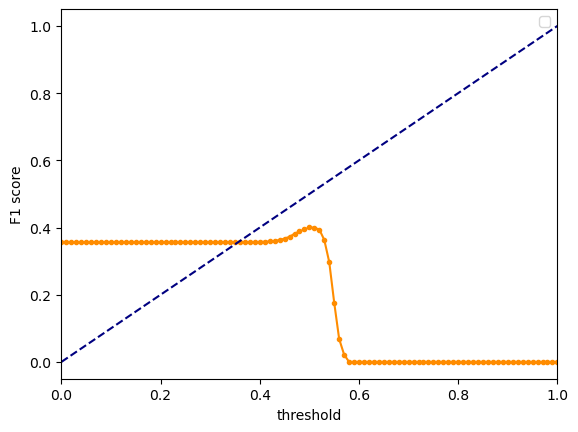

In [62]:
thresholds = np.arange(0, 1.1, 0.01)
f1 = []

y_test_proba=xg_fitted.predict_proba(X_test)[:, 1]

for threshold in thresholds:

    # Apply threshold
    y_threshold = np.where(y_test_proba >= threshold, 1, 0)
    f1.append(f1_score(y_test, y_threshold))

# plot    
plt.figure()
plt.plot(thresholds, f1, color='darkorange', marker='.')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim(0, 1)
plt.xlabel('threshold')
plt.ylabel('F1 score')
plt.legend()
plt.show()

In [63]:
# get index of the highest f1
highest_f1_index=np.argmax(f1)

# get the threshold giving the highest f1 
optimal_threshold=thresholds[highest_f1_index]

print(f'Optimal threshold: {optimal_threshold}')
print(f'\nHighest F1 score: {f1[highest_f1_index]}')

Optimal threshold: 0.5

Highest F1 score: 0.4001083513918986


In [64]:
y_train_proba=xg_fitted.predict_proba(X_train)[:, 1]
y_test_proba=xg_fitted.predict_proba(X_test)[:, 1]

y_train_threshold = np.where(y_train_proba >= optimal_threshold, 1, 0)
y_test_threshold = np.where(y_test_proba >= optimal_threshold, 1, 0)

print(f'Train Accuracy: %.3f' % accuracy_score(y_train, y_train_threshold))
print(f'Test Accuracy: %.3f' % accuracy_score(y_test, y_test_threshold))
print(f'Accuracy difference: %.3f' % (accuracy_score(y_train, y_train_threshold)-accuracy_score(y_test, y_test_threshold)).round(4))

Train Accuracy: 0.514
Test Accuracy: 0.506
Accuracy difference: 0.008


# Conclusion <a class="anchor" id="conclusion"></a>

Afterall, I would choose XGBoost at threshold **0.5** or its default threshold as the ultimate model for this dataset.

# Feature Selection <a class="anchor" id="fs"></a>

Since this dataset contains a mix of categorical and numeric values, I would utilize **Feature Importance** since it can select features across categorical and numeric types.

Importance scores will be derived from the most optimal model that has been found - XGBoost.

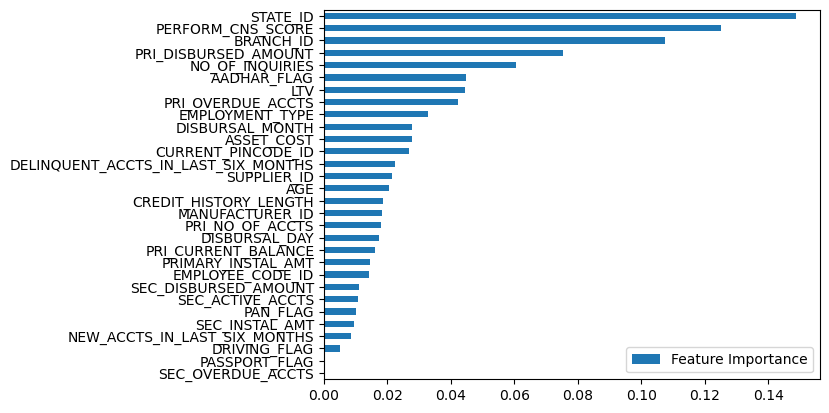

In [77]:
# In the final model, I would apply OneHotEncode (OHE) for the categorical features, 
# but to determine feature importance, I don't want to expand the columns with OHE, 
# also I believe that we'll get more value out of treating them as one column with ordinal encoded values.

fs_pipeline = make_pipeline(
            RandomOverSampler(random_state=101, sampling_strategy=1/3),
            make_column_transformer((OrdinalEncoder(), make_column_selector(dtype_include=object)), #OE all object columns
                                     remainder='passthrough'),#pass through the rest (numeric) columns
            XGBClassifier(random_state=22, 
                        n_estimators=55,
                        max_depth=7,
                        learning_rate=0.0058000000000000005,
                        reg_lambda=0.0085,
                        gamma=0.0088, scale_pos_weight=3.6068022551240846))


xg_fs = fs_pipeline.fit(X_train, y_train)

# get feature importance
f_importance=xg_fs.named_steps['xgbclassifier'].feature_importances_

# put into a dataframe
importance_df = pd.DataFrame(f_importance, index=X_train.columns, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
importance_df.sort_values(by='Feature Importance').plot.barh()
plt.show()

We see that `STATE_ID` is the most important feature, this matches with EDA findings.

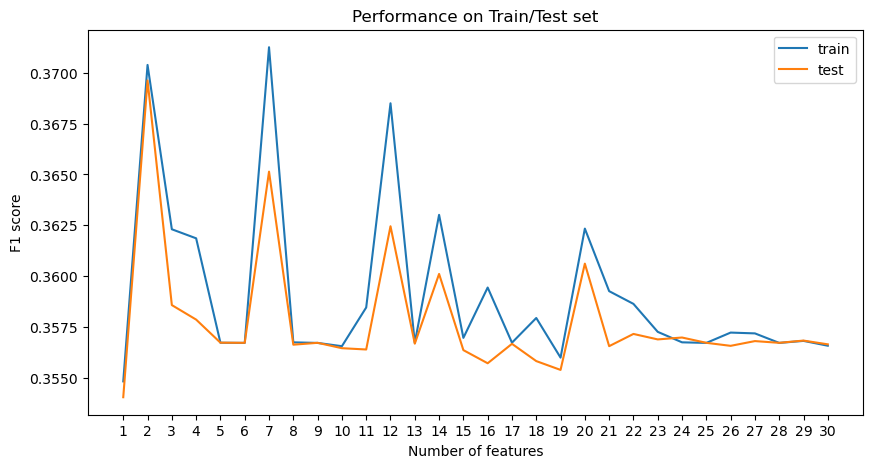

In [100]:
# let's look at how different sets of top features work
train_f1=[]
test_f1=[]

for i in range (len(importance_df.index)):
    # define dataframes
    X_train_fs=X_train[[importance_df.index[i]]]
    X_test_fs=X_test[[importance_df.index[i]]]

    # fit
    xg_fs.fit(X_train_fs, y_train)
    
    # predict 
    y_train_proba=xg_fs.predict_proba(X_train_fs)[:, 1]
    y_test_proba=xg_fs.predict_proba(X_test_fs)[:, 1]

    # apply optimal threshold
    y_train_threshold = np.where(y_train_proba >= optimal_threshold, 1, 0)
    y_test_threshold = np.where(y_test_proba >= optimal_threshold, 1, 0)
    
    #score
    train_f1.append(f1_score(y_train, y_train_threshold))
    test_f1.append(f1_score(y_test, y_test_threshold))

#plot
plt.figure(figsize=(10,5))
plt.plot(range(1,len(importance_df.index)+1), train_f1, label="train")
plt.plot(range(1,len(importance_df.index)+1), test_f1, label="test")
plt.xticks(range(1,len(importance_df.index)+1))
plt.xlabel('Number of features')
plt.ylabel("F1 score")
plt.title("Performance on Train/Test set")
plt.legend()
plt.show()

In [102]:
# let's check
X_train_2=X_train[['STATE_ID','PERFORM_CNS_SCORE']]
X_test_2=X_test[['STATE_ID','PERFORM_CNS_SCORE']]
xg_fs_2 = xg_fs.fit(X_train_2,y_train)

y_train_proba=xg_fs_2.predict_proba(X_train_2)[:, 1]
y_test_proba=xg_fs_2.predict_proba(X_test_2)[:, 1]

y_train_threshold = np.where(y_train_proba >= optimal_threshold, 1, 0)
y_test_threshold = np.where(y_test_proba >= optimal_threshold, 1, 0)

print(f'Train Accuracy: %.3f' % accuracy_score(y_train, y_train_threshold))
print(f'Test Accuracy: %.3f' % accuracy_score(y_test, y_test_threshold))
print(f'Accuracy difference:  %.3f' % (accuracy_score(y_train, y_train_threshold)-accuracy_score(y_test, y_test_threshold)).round(4))
print(f'Train F1 score: %.3f' % f1_score(y_train, y_train_threshold))
print(f'Test F1 score: %.3f' % f1_score(y_test, y_test_threshold))

Train Accuracy: 0.435
Test Accuracy: 0.431
Accuracy difference:  0.004
Train F1 score: 0.373
Test F1 score: 0.370


To sum up, `STATE_ID` and `PERFORM_CNS_SCORE` are two highly predictive features of this dataset.

# Prioritized Segment <a class="anchor" id="ps"></a>

Let's look at those who the model predicts to have defaulted but they turned out not.

In [103]:
# predict the whole dataset
df['Prediction']=xg_fitted.predict(df)
# filter out the segment
prioritized_segment=df.where((df['Prediction']==1) & (df['LOAN_DEFAULT']==0)).dropna()
prioritized_segment

,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,EMPLOYMENT_TYPE,STATE_ID,EMPLOYEE_CODE_ID,AADHAR_FLAG,PAN_FLAG,DRIVING_FLAG,PASSPORT_FLAG,PERFORM_CNS_SCORE,PRI_NO_OF_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_DISBURSED_AMOUNT,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT,DISBURSAL_MONTH,DISBURSAL_DAY,AGE,Prediction
UNIQUEID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
420825,58400.0,89.55,67.0,22807.0,45.0,1441.0,Salaried,6.0,1998.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0,39.0,1.0
417566,61360.0,89.63,67.0,22807.0,45.0,1497.0,Self employed,6.0,1998.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,38.0,1.0
529269,61500.0,76.42,67.0,22807.0,45.0,1502.0,Salaried,6.0,1998.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,23.0,35.0,1.0
486821,74190.0,89.23,67.0,22807.0,45.0,1446.0,Salaried,6.0,1998.0,1.0,0.0,0.0,0.0,786.0,3.0,0.0,676.0,23374.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,1.0,0.0,3.0,9.0,39.0,1.0
513916,65750.0,89.28,67.0,22807.0,45.0,1440.0,Self employed,6.0,1998.0,1.0,0.0,0.0,0.0,300.0,6.0,2.0,29069.0,1067200.0,0.0,0.0,0.0,47100.0,0.0,1.0,1.0,66.0,0.0,0.0,9.0,18.0,47.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479107,78437.0,79.04,101.0,24031.0,120.0,687.0,Self employed,15.0,3198.0,1.0,0.0,0.0,0.0,738.0,3.0,0.0,82064.0,83000.0,0.0,0.0,0.0,10480.0,0.0,1.0,0.0,23.0,1.0,0.0,8.0,30.0,31.0,1.0
606173,69001.0,84.78,34.0,23024.0,86.0,987.0,Self employed,6.0,3705.0,1.0,0.0,0.0,0.0,738.0,3.0,0.0,7326.0,10990.0,0.0,0.0,0.0,4665.0,0.0,1.0,0.0,8.0,0.0,0.0,10.0,23.0,29.0,1.0
613161,69001.0,83.04,34.0,23024.0,86.0,1044.0,Salaried,6.0,3705.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,24.0,60.0,1.0


These **102334** customers are those who the model predicts that they should have defaulted but actually not (yet), and with the assumption of a good model performance, it's suggested to ask these customers to mortgage some sort of security against their loan since they are likely to default in the future.